# Gaussian regression of candidate scores: correlated categories.

We will set up a Gaussian regression model as in the `gaussian_analysis_single_category.ipynb` notebook, but we will now enhance it with a generative model for the scores that allows for intrinsic correlations in the true scores of a candidate over the three score categories (`Originality/Creativity`, `Importance to the Field`, `Clarity`).

We imagine the true scores are drawn from a 3x3 multivariate Gaussian normal with covariance $\Sigma$, such that 
$$
\mu_i \sim \mathcal{N}(\Mu, \Sigma)
$$
We will set a broad Gaussian prior on $\Mu \sim \mathcal{N}(5, 5)$, based on the fact that the scores are produced on a scale from 1-10. For $\Sigma$, we will use an LKJ prior.

In [ ]:
%matplotlib inline

In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

# some default imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# we will use arviz for some of the plotting
import arviz as az

# import jax and set it up to use double precision
from jax import config
config.update("jax_enable_x64", True)

import numpyro
numpyro.set_host_device_count(4)
numpyro.set_platform('cpu')

from jax import numpy as jnp, random
from numpyro import sample, handlers
import numpyro.distributions as dist
from numpyro.distributions import (
    Categorical,
    Dirichlet,
    ImproperUniform,
    Normal,
    OrderedLogistic,
    TransformedDistribution,
    constraints,
    transforms,
    LKJCholesky
)
from numpyro.infer import MCMC, NUTS
from numpyro.infer.reparam import TransformReparam

# set plotting context
sns.set_context('notebook')
sns.set_palette('colorblind')

## Data setup

Load the ranking data.

In [3]:
# load anonimized data
data = pd.read_csv('ranking_data_anon.csv')
data.replace('x', np.nan, inplace=True)
data.replace('-', np.nan, inplace=True)
data.iloc[:5]

,Judge,Category,Candidate-0,Candidate-1,Candidate-2,Candidate-3,Candidate-4,Candidate-5,Candidate-6,Candidate-7,...,Candidate-28,Candidate-29,Candidate-30,Candidate-31,Candidate-32,Candidate-33,Candidate-34,Candidate-35,Candidate-36,Candidate-37
0,Judge-0,Orig/ Creat.,6,7,9,9,7,8,8,7,...,7,5,6,7,8,6,9,6,8,7
1,Judge-0,Imp. Field,6,8,9,9,8,7,7,7,...,6,7,6,8,8,7,9,6,8,8
2,Judge-0,Clarity,6,7,9,9,8,8,7,7,...,7,6,6,8,8,7,8,8,8,7
3,Judge-0,Confidence,3,3,1,1,1,2,2,3,...,1,3,3,2,1,3,1,3,2,3
4,Judge-1,Orig/ Creat.,6,7,9,8,7,6,7,6,...,6,7,6,8,8,6,8,6,7,6


In [4]:
candidates = [c for c in data.columns if 'Candidate' in c]
judges = data['Judge'].unique()
categories = [c for c in data['Category'].unique() if c != 'Confidence']

In [5]:
confidence = data[data['Category'] == 'Confidence'][candidates]
sigma = confidence.astype(float).values

x = np.array([g[candidates].values for k,g in data.groupby('Category') if k != 'Confidence'])
x = x.astype(float)

# patch missing scores with uninformative values
for xcat in x:
    missing = np.isnan(xcat) | np.isnan(sigma)
    xcat[missing] = 5
    sigma[missing] = 5

In [6]:
n_categories, n_judges, n_candidates = x.shape

In [10]:
x.shape, sigma.shape

((3, 9, 38), (9, 38))

## Joint Gaussian model

In [44]:
def model(x=None, sigma=sigma):
    n_categories, n_judges, n_candidates = x.shape
    
    mu = sample('meta_mu', Normal(5, 5), sample_shape=(n_categories,))
    # LKJ prior for a correlation matrix
    
    # Vector of variances for each of the d variables
    theta = sample("theta", dist.HalfCauchy(jnp.ones(n_categories)))

    concentration = jnp.ones(1)  # Implies a uniform distribution over correlation matrices
    corr_mat = sample("corr_mat", dist.LKJ(n_categories, concentration))
    s = jnp.sqrt(theta)
    # we can also use a faster formula `cov_mat = jnp.outer(sigma, sigma) * corr_mat`
    cov_mat = jnp.matmul(jnp.matmul(jnp.diag(s), corr_mat), jnp.diag(s))
    
    # save cov_mat as deterministic
    numpyro.deterministic('cov_mat', cov_mat)
    
    with numpyro.plate("candidates", n_candidates):
        scores = sample("scores", dist.MultivariateNormal(mu, covariance_matrix=cov_mat))
    
    # scores is now shaped (n_candidates, n_categories)
    # reshape all arrays to (n_categories, n_judges, n_candidates)
    beta = sample('beta', Normal(0, 2), sample_shape=(1, n_judges, 1))
    sigma = sigma[jnp.newaxis, :, :]
    scores = jnp.transpose(scores)[:,jnp.newaxis,:]
    obs = sample('x', Normal(scores + beta, sigma), obs=x)

key = random.PRNGKey(1234)
mcmc_key, pred_key = random.split(key)
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=250, num_samples=750, num_chains=4)
mcmc.run(mcmc_key, x=x)

result = az.from_numpyro(mcmc)

# get posterior predictive
# predictive = numpyro.infer.Predictive(model, mcmc.get_samples())
# pred = predictive(pred_key)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

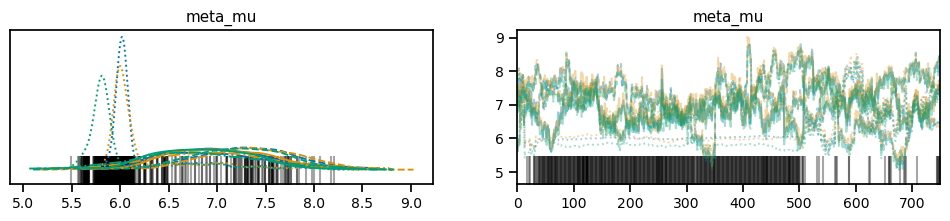

In [45]:
az.plot_trace(result, var_names=['meta_mu']);

In [46]:
result.posterior.cov_mat[0,0,:,:]

<xarray.DataArray 'cov_mat' (cov_mat_dim_0: 1, cov_mat_dim_1: 3,
                             cov_mat_dim_2: 3)> Size: 72B
array([[[0.25662083, 0.20142943, 0.32504442],
        [0.20142943, 0.53503581, 0.5071441 ],
        [0.32504442, 0.5071441 , 0.58991708]]])
Coordinates:
    chain          int64 8B 0
    draw           int64 8B 0
  * cov_mat_dim_0  (cov_mat_dim_0) int64 8B 0
  * cov_mat_dim_1  (cov_mat_dim_1) int64 24B 0 1 2
  * cov_mat_dim_2  (cov_mat_dim_2) int64 24B 0 1 2

In [47]:
samples = result.posterior.stack(sample=('chain', 'draw'))

In [48]:
samples.scores.shape, samples.beta.shape

((38, 3, 3000), (1, 9, 1, 3000))

In [49]:
mu = np.moveaxis(samples.scores.values, 0, 1)
beta = np.squeeze(samples.beta.values)

In [50]:
mu_df = pd.DataFrame()
for cat, mu_cat in zip(categories, mu):
    df = pd.DataFrame(mu_cat.T, columns=candidates)
    df['Category'] = cat
    mu_df = pd.concat([mu_df, df], ignore_index=True)

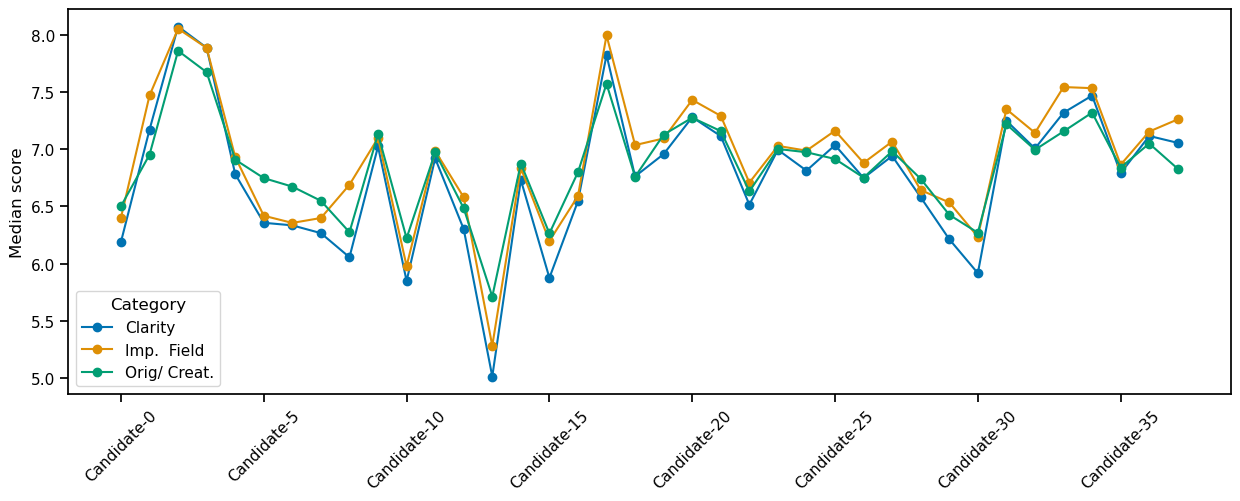

In [51]:
median_score = mu_df.groupby('Category').median()

median_score.T.plot(marker='o', figsize=(15, 5))
plt.ylabel('Median score')
plt.xticks(rotation=45);

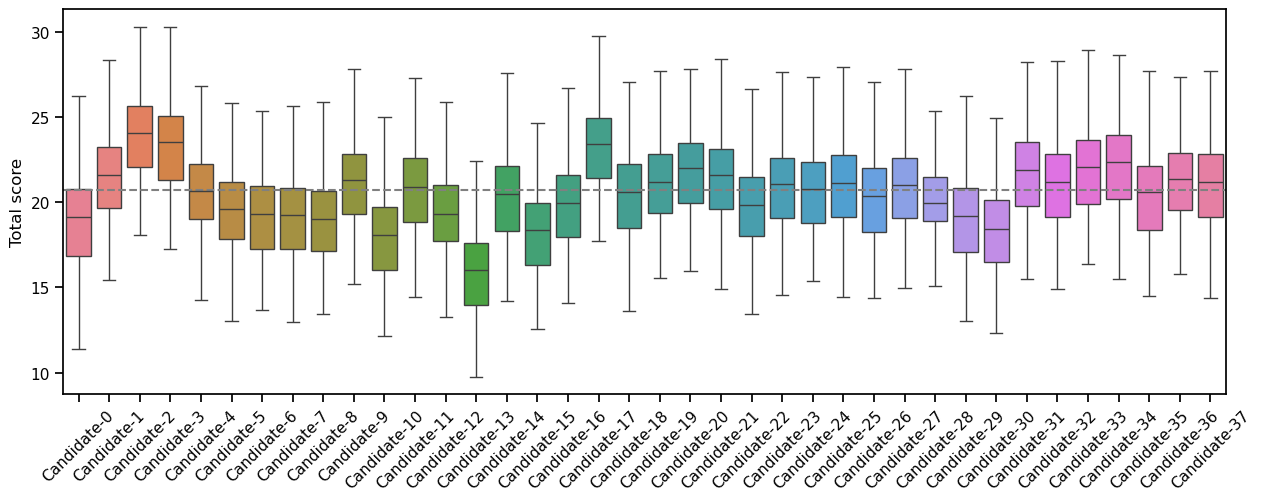

In [52]:
score_sum = np.sum(mu, axis=0)

df = pd.DataFrame(score_sum.T, columns=candidates)

median_total_score = df.median().median()

# boxplot without showing outliers
plt.figure(figsize=(15, 5))
sns.boxplot(df, showfliers=False)

plt.axhline(median_total_score, color='gray', linestyle='--')

plt.ylabel("Total score")

# tilt the x-axis labels
plt.xticks(rotation=45);

['Candidate-2', 'Candidate-3', 'Candidate-17', 'Candidate-31', 'Candidate-36', 'Candidate-34']


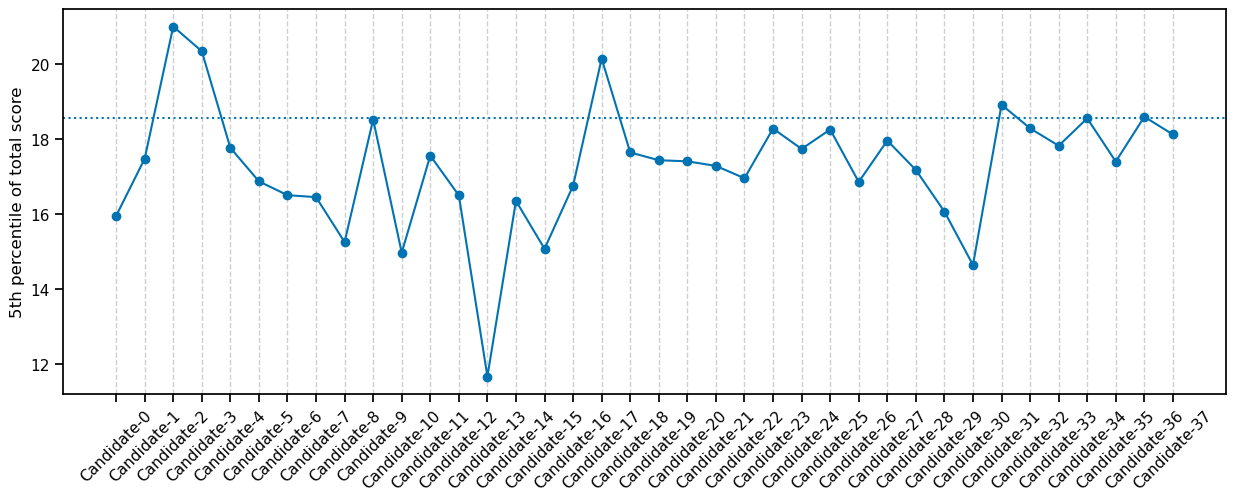

In [53]:
# fraction_above_median = np.apply_along_axis(lambda y: len(y[y > median_total_score])/len(y), 1, score_sum)
# [c for q,c in sorted(zip(fraction_above_median, candidates), reverse=True)][:6]

# plt.figure(figsize=(15, 5))
# plt.plot(candidates, fraction_above_median, 'o-')
# plt.ylabel("Fraction of total score above global median")
# plt.xticks(rotation=45);

total_lower_limit = np.apply_along_axis(lambda y: np.quantile(y, 0.05), 1, score_sum)
ranked_candidates = pd.Series(total_lower_limit, index=candidates).sort_values(ascending=False)
print(list(ranked_candidates.index.values)[:6])

plt.figure(figsize=(15, 5))
plt.plot(candidates, total_lower_limit, 'o-')
plt.axhline(ranked_candidates.iloc[5], linestyle=':', zorder=-1)
plt.ylabel("5th percentile of total score")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.xticks(rotation=45);

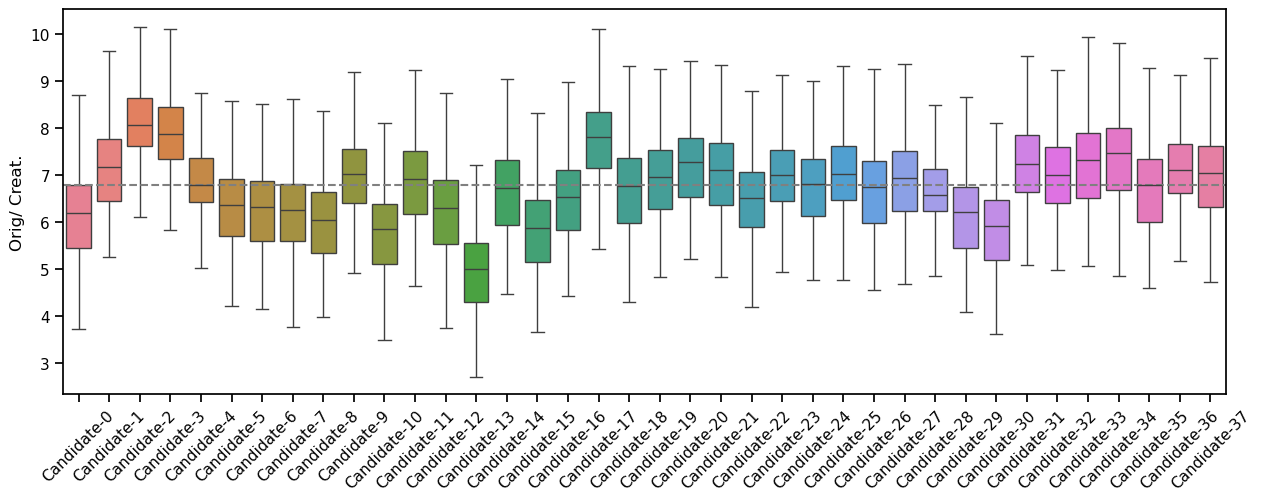

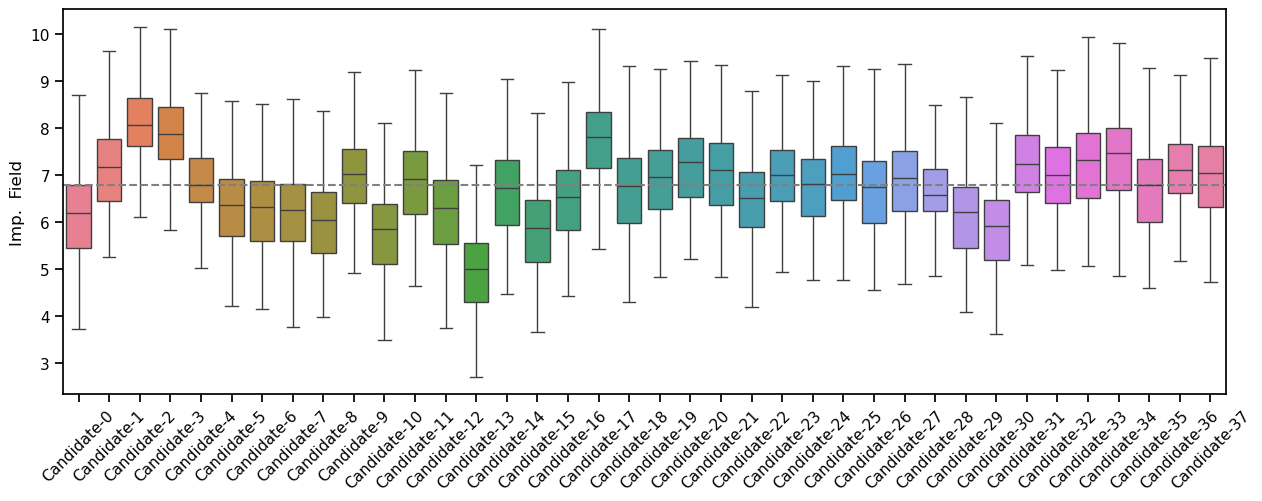

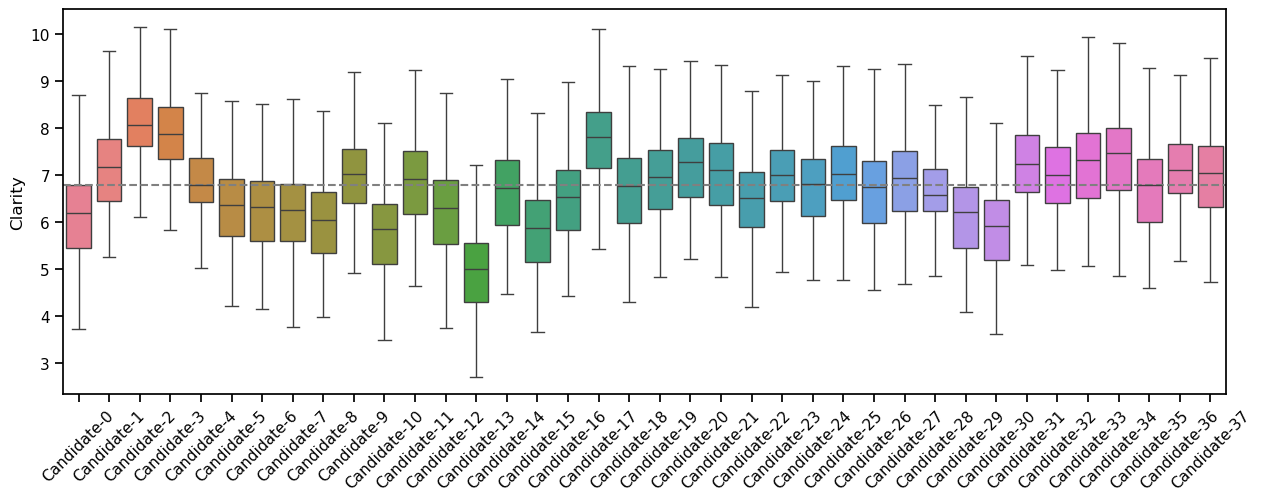

In [54]:
for cat, df in zip(categories, mu):
    
    df = pd.DataFrame(mu_cat.T, columns=candidates)

    m = df.median().median()

    # boxplot without showing outliers
    plt.figure(figsize=(15, 5))
    sns.boxplot(df, showfliers=False)

    plt.axhline(m, color='gray', linestyle='--')

    plt.ylabel(cat)

    # tilt the x-axis labels
    plt.xticks(rotation=45);

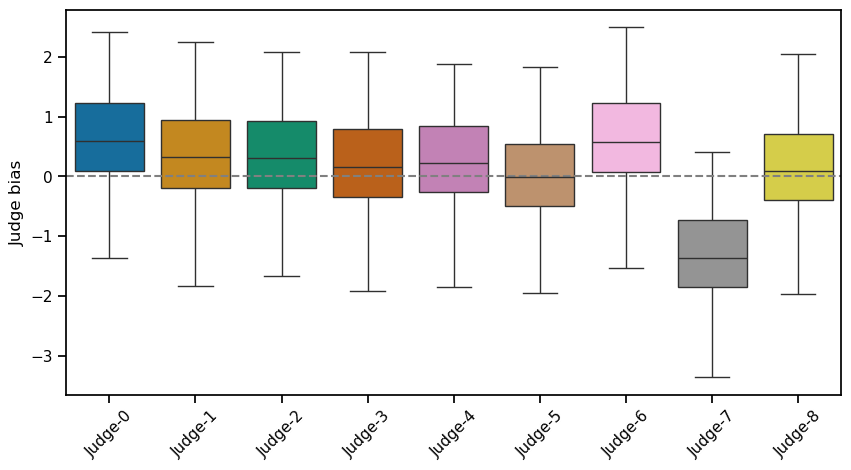

In [55]:
df = pd.DataFrame(beta.T, columns=judges)
# boxplot without showing outliers
plt.figure(figsize=(10, 5))
sns.boxplot(df, showfliers=False)
plt.axhline(0, color='gray', linestyle='--')
plt.ylabel('Judge bias')
# tilt the x-axis labels
plt.xticks(rotation=45);

What was the correlation across categories?

In [56]:
covs = np.squeeze(samples.cov_mat.values)
corrs = np.squeeze(samples.corr_mat.values)

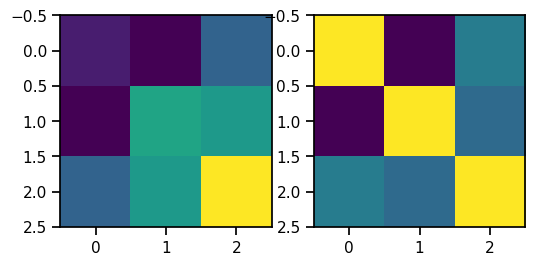

In [57]:
# plot the median covariance and correlation matrices
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(np.median(covs, axis=-1), cmap='viridis');
axs[1].imshow(np.median(corrs, axis=-1), cmap='viridis');